# Классификация цветов с помощью свёрточных нейронных сетей.


В работе необходимо познакомится с различными архитектурами сверхточных нейронных сетей и их обучением на GPU (англ. graphics processing, графический процессор) на языке программирования Python 3 и фреймворка Torch (PyTorch).  Для этого предлагается использовать ресурсы Google Colab - Colaboratory, для выполнения вычислений на GPU. После с ознакомления, выполнить практическое задане в конце данной тетради (notebook).

Рассмотрим [Датасет](https://www.kaggle.com/alxmamaev/flowers-recognition ) содержащий 4242 изображения цветов размеченных по 5 видам (тюльпан, ромашка, подсолнух, роза, одуванчик). Данный набор данных можно скачать по [ссылке](https://www.kaggle.com/alxmamaev/flowers-recognition ) с сайте kaggle.

Загрузите папку с картинками на гугл диск, чтобы не загружать ее каждый раз заново при перезапуске колаба. Структура файлов (можно посмотреть в меню слева) может быть такой: "/content/drive/My Drive/data/flowers".
Обязательно подключите аппаратный ускоритель (GPU) к среде выполнения, чтобы вычисления были. В меню сверху: Среда выполнения -> Сменить среду выполнения

Первым делом разберите более детально код выполнив код ниже.

# Подготовка

Загружаем библиотеки. Фиксируем random.seed для воспроизводимости

In [ ]:
import numpy as np # linear algebra
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'data/flowers'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
#%cp -r $FOLDERNAME ../../
#%cd ../../
%cd data/flowers/
#!bash get_datasets.sh
#%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/data/flowers


In [ ]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)
# задаем датасет. Лейблы - имена папок: 
dataset = ImageFolder('/content/drive/My Drive/data/flowers', transform=prepare_imgs)

In [ ]:
dataset.imgs[2]

('/content/drive/My Drive/data/flowers/daisy/10172379554_b296050f82_n.jpg', 0)

In [ ]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы 
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


# Сверточная нейросеть с нуля

## Вручную прописываем слои

In [ ]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
model.to(device) # отправляем модель на девайс (GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=200704, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Lin

Задаем гиперпараметры для обучения:

# Задаем параметры и функцию для обучения. Разбиваем датасет на train/validation

In [ ]:
batch_size = 32 # размер батча
optimizer = torch.optim.Adam(params = model.parameters()) # алгоритм оптимизации
lr = 0.001 # learning rate

Разбиваем датасет на train и validation

Задаем dataloader'ы - объекты для итеративной загрузки данных и лейблов для обучения и валидации

In [ ]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Размер обучающего и валидационного датасета:  3317 1000


Функция для подсчета Accuracy

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция для обучения и валидации модели

In [ ]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    optimizer: оптимизатор
    epochs: число обучающих эпох (сколько раз пройдемся по всему датасету)
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'validation']: # обучение - валидация
            # считаем градиаент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимоти от фазы переводим модель в нужный ружим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # отправляем тензор на GPU
                    labels = labels.to(device) 
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track             

# Обучаем базовую модель

Проверим загрузку видеокарты, прежде чем запустить обучение:

In [ ]:
!nvidia-smi

Thu Dec 16 11:27:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    74W / 149W |   1321MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Запускаем обучение на 10 эпох

In [ ]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10)

100%|██████████| 104/104 [04:07<00:00,  2.38s/it]


[training] Epoch: 0.00. Loss: 1.43. Accuracy: 35.51% 


100%|██████████| 32/32 [01:08<00:00,  2.14s/it]


[validation] Epoch: 0.00. Loss: 1.39. Accuracy: 38.20% 


100%|██████████| 104/104 [01:16<00:00,  1.36it/s]


[training] Epoch: 1.00. Loss: 1.31. Accuracy: 42.36% 


100%|██████████| 32/32 [00:10<00:00,  2.93it/s]


[validation] Epoch: 1.00. Loss: 1.26. Accuracy: 44.40% 


100%|██████████| 104/104 [01:16<00:00,  1.37it/s]


[training] Epoch: 2.00. Loss: 1.21. Accuracy: 48.25% 


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


[validation] Epoch: 2.00. Loss: 1.17. Accuracy: 49.87% 


100%|██████████| 104/104 [01:16<00:00,  1.37it/s]


[training] Epoch: 3.00. Loss: 1.11. Accuracy: 53.27% 


100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


[validation] Epoch: 3.00. Loss: 1.12. Accuracy: 53.20% 


100%|██████████| 104/104 [01:16<00:00,  1.36it/s]


[training] Epoch: 4.00. Loss: 1.01. Accuracy: 58.00% 


100%|██████████| 32/32 [00:10<00:00,  3.07it/s]


[validation] Epoch: 4.00. Loss: 1.12. Accuracy: 55.04% 


100%|██████████| 104/104 [01:16<00:00,  1.37it/s]


[training] Epoch: 5.00. Loss: 0.91. Accuracy: 62.67% 


100%|██████████| 32/32 [00:10<00:00,  3.05it/s]


[validation] Epoch: 5.00. Loss: 1.17. Accuracy: 56.43% 


100%|██████████| 104/104 [01:16<00:00,  1.37it/s]


[training] Epoch: 6.00. Loss: 0.81. Accuracy: 67.00% 


100%|██████████| 32/32 [00:10<00:00,  3.02it/s]


[validation] Epoch: 6.00. Loss: 1.28. Accuracy: 57.17% 


100%|██████████| 104/104 [01:16<00:00,  1.37it/s]


[training] Epoch: 7.00. Loss: 0.72. Accuracy: 70.65% 


100%|██████████| 32/32 [00:11<00:00,  2.89it/s]


[validation] Epoch: 7.00. Loss: 1.42. Accuracy: 57.50% 


100%|██████████| 104/104 [01:16<00:00,  1.36it/s]


[training] Epoch: 8.00. Loss: 0.66. Accuracy: 73.53% 


100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


[validation] Epoch: 8.00. Loss: 1.50. Accuracy: 57.90% 


100%|██████████| 104/104 [01:16<00:00,  1.36it/s]


[training] Epoch: 9.00. Loss: 0.60. Accuracy: 75.93% 


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]

[validation] Epoch: 9.00. Loss: 1.56. Accuracy: 57.59% 


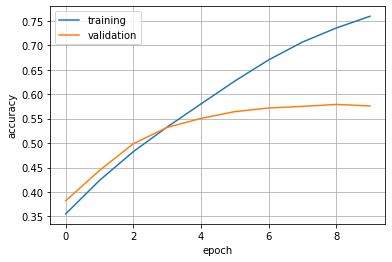

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

# Fine-tuning предобученной модели

Теперь попробуем поработать с предобученной сетью ResNet-18

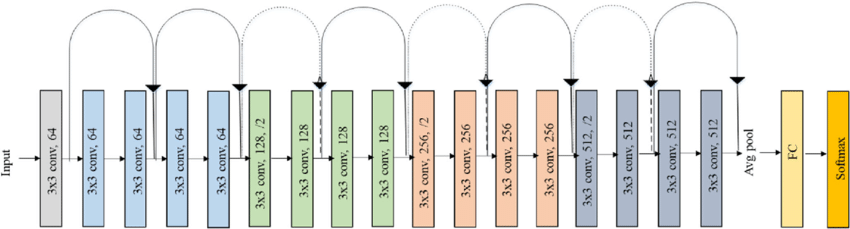

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True) # инициализируем модель
resnet

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def set_parameter_requires_grad(model):
  """
  Функция для заморозки весов модели
  """
  for param in model.parameters():
    param.requires_grad = False
            
set_parameter_requires_grad(resnet)

In [ ]:
# Меняем последний слой модели, чтобы он предсказывал 5 классов, а не 1000
# Когда мы заново определяем слой, у него по умолчанию стоит аттрибут requires_grad = True
# То есть этот полносвязный слой будет обучаться
resnet.fc = nn.Linear(512, 5)

In [ ]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in resnet.named_parameters():
    if param.requires_grad:
        print(name)

fc.weight
fc.bias


Запустим функцию обучения модели. Внимание - необходимо заново задать оптимизатор, чтобы он теперь работал с весами resnet

In [ ]:
resnet.to(device)
optimizer = torch.optim.Adam(params = resnet.parameters()) # алгоритм оптимизации
loss_track, accuracy_track = trainval(resnet, loaders, optimizer, epochs=5)

100%|██████████| 104/104 [00:21<00:00,  4.79it/s]


[training] Epoch: 0.00. Loss: 0.89. Accuracy: 68.80% 


100%|██████████| 32/32 [00:06<00:00,  4.81it/s]


[validation] Epoch: 0.00. Loss: 0.54. Accuracy: 83.60% 


100%|██████████| 104/104 [00:21<00:00,  4.79it/s]


[training] Epoch: 1.00. Loss: 0.70. Accuracy: 76.03% 


100%|██████████| 32/32 [00:06<00:00,  4.83it/s]


[validation] Epoch: 1.00. Loss: 0.48. Accuracy: 84.45% 


100%|██████████| 104/104 [00:21<00:00,  4.84it/s]


[training] Epoch: 2.00. Loss: 0.60. Accuracy: 79.55% 


100%|██████████| 32/32 [00:06<00:00,  4.84it/s]


[validation] Epoch: 2.00. Loss: 0.46. Accuracy: 84.97% 


100%|██████████| 104/104 [00:21<00:00,  4.85it/s]


[training] Epoch: 3.00. Loss: 0.54. Accuracy: 81.50% 


100%|██████████| 32/32 [00:06<00:00,  4.79it/s]


[validation] Epoch: 3.00. Loss: 0.44. Accuracy: 85.30% 


100%|██████████| 104/104 [00:21<00:00,  4.74it/s]


[training] Epoch: 4.00. Loss: 0.51. Accuracy: 82.86% 


100%|██████████| 32/32 [00:06<00:00,  4.83it/s]

[validation] Epoch: 4.00. Loss: 0.42. Accuracy: 85.52% 


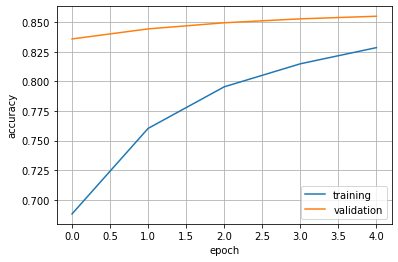

In [ ]:
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

Сохраним веса модели:

In [ ]:
weights_fname = '/content/drive/My Drive/data/flower-resnet.pth'
torch.save(resnet.state_dict(), weights_fname)

# Смотрим результат

И посмотрим как модель предсказывает

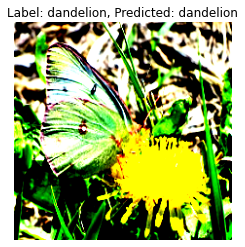

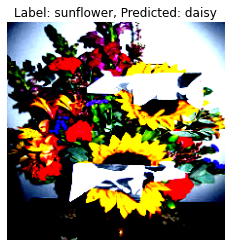

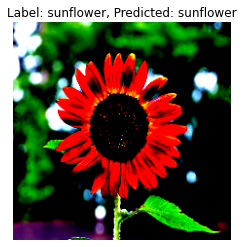

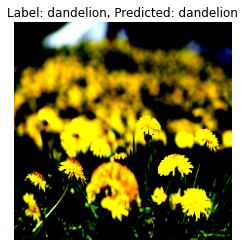

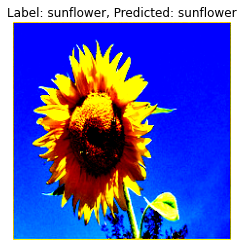

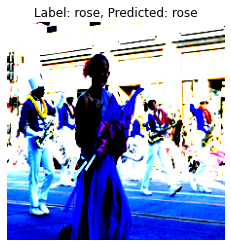

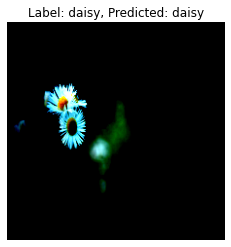

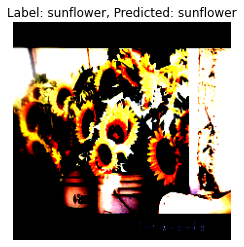

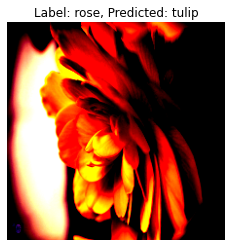

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, resnet)))
  plt.show()
  # print('Label:', dataset.classes[label], ',Predicted:', predict_image(img, resnet))

# Практическое задание 

В пракическом задание необходимо обучить еще одну сверточную архитектуру для задач классификации цветов. 

В выбранной Вами архитектуре также необходимо разобраться с основными её параметрами и принципами работы.

Посмотрите как использовать [модели в PyTorch](https://pytorch.org/vision/stable/models.html), выберите одну и используя transfer learning до-обучите модель на классификацию цветов. Чтобы это сделать замените ____ в ячейках ниже на работающий код.




In [24]:
# Выберите модель из списка доступных в PyTorch моделей
# Не забудьте указать, что она модель должна быть предобучена!
model =torchvision.models.densenet169(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


  0%|          | 0.00/54.7M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [25]:
set_parameter_requires_grad(model) # передайте модель в функцию для "заморозки" градиента

In [41]:
model.classifier = nn.Linear(1664,5) # Меняем последний слой модели
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [42]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

classifier.weight
classifier.bias


In [43]:
model.to(device) # Отправляем модель на GPU
optimizer = torch.optim.Adam(params = model.parameters()) # алгоритм оптимизации
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10) # запускаем обучение

100%|██████████| 104/104 [00:33<00:00,  3.12it/s]


[training] Epoch: 0.00. Loss: 0.75. Accuracy: 76.45% 


100%|██████████| 32/32 [00:09<00:00,  3.23it/s]


[validation] Epoch: 0.00. Loss: 0.42. Accuracy: 88.40% 


100%|██████████| 104/104 [00:32<00:00,  3.15it/s]


[training] Epoch: 1.00. Loss: 0.57. Accuracy: 82.14% 


100%|██████████| 32/32 [00:10<00:00,  3.20it/s]


[validation] Epoch: 1.00. Loss: 0.38. Accuracy: 88.60% 


100%|██████████| 104/104 [00:32<00:00,  3.16it/s]


[training] Epoch: 2.00. Loss: 0.49. Accuracy: 84.70% 


100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


[validation] Epoch: 2.00. Loss: 0.35. Accuracy: 89.47% 


100%|██████████| 104/104 [00:32<00:00,  3.17it/s]


[training] Epoch: 3.00. Loss: 0.44. Accuracy: 86.31% 


100%|██████████| 32/32 [00:09<00:00,  3.25it/s]


[validation] Epoch: 3.00. Loss: 0.34. Accuracy: 89.67% 


100%|██████████| 104/104 [00:32<00:00,  3.17it/s]


[training] Epoch: 4.00. Loss: 0.40. Accuracy: 87.34% 


100%|██████████| 32/32 [00:09<00:00,  3.25it/s]


[validation] Epoch: 4.00. Loss: 0.33. Accuracy: 89.96% 


100%|██████████| 104/104 [00:32<00:00,  3.17it/s]


[training] Epoch: 5.00. Loss: 0.37. Accuracy: 88.16% 


100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


[validation] Epoch: 5.00. Loss: 0.32. Accuracy: 90.18% 


100%|██████████| 104/104 [00:32<00:00,  3.16it/s]


[training] Epoch: 6.00. Loss: 0.35. Accuracy: 88.79% 


100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


[validation] Epoch: 6.00. Loss: 0.31. Accuracy: 90.49% 


100%|██████████| 104/104 [00:32<00:00,  3.16it/s]


[training] Epoch: 7.00. Loss: 0.33. Accuracy: 89.38% 


100%|██████████| 32/32 [00:09<00:00,  3.25it/s]


[validation] Epoch: 7.00. Loss: 0.30. Accuracy: 90.61% 


100%|██████████| 104/104 [00:32<00:00,  3.16it/s]


[training] Epoch: 8.00. Loss: 0.32. Accuracy: 89.83% 


100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


[validation] Epoch: 8.00. Loss: 0.30. Accuracy: 90.74% 


100%|██████████| 104/104 [00:32<00:00,  3.16it/s]


[training] Epoch: 9.00. Loss: 0.30. Accuracy: 90.27% 


100%|██████████| 32/32 [00:09<00:00,  3.25it/s]

[validation] Epoch: 9.00. Loss: 0.29. Accuracy: 90.92% 


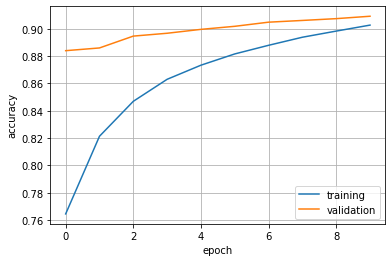

In [44]:
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

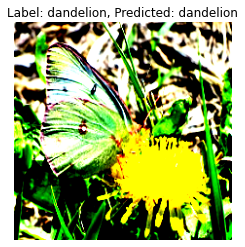

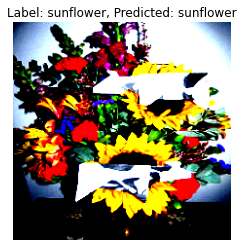

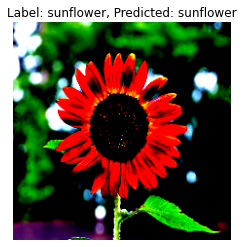

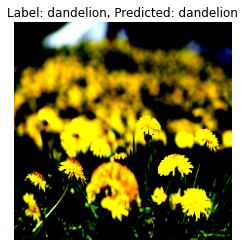

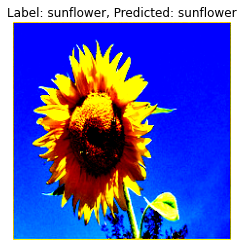

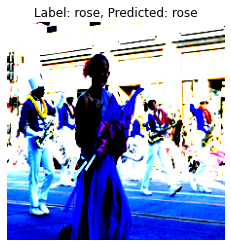

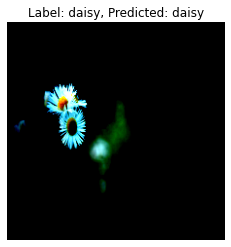

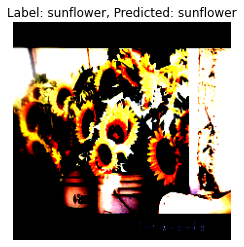

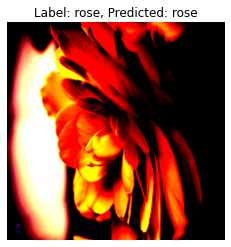

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label], predict_image(img, model)))
  plt.show()
  # print('Label:', dataset.classes[label], ',Predicted:', predict_image(img, ______))

По желанию, можно сохранить веса модели.

In [47]:
weights_fname = '/content/drive/My Drive/data/***___**.pth'
torch.save(model.state_dict(), weights_fname)

## Вопросы.

Как работает выбранная вами модель сверточной нейронной сети? Какие параметры?

В чем основные отличия между сверточной нейронной сетью и "обычной" полносвязной нейронной сетью?

Что такое transfer learning?

Что такое функция для заморозки весов модели?


Ответы на вопросы:

1. Сначала объясню мотивацию выбора модели. Почитал про несколько из них на сайте pyTorch. Позже узнал, у друга, что тот использовал alexnet в сравнении с resnet, поэтому данные две модели решил не использовать, а попробовать другие. Выполнил лабу для модели vgg, результаты получились чуть хуже, чем у представленной в отчете модели. Связываю с тем, что документация по vgg предлагает ее использовать для крупномасштабных изображений, а наш датасет из 4000 картинов занимает всего ~300 мб, поэтому вряд ли их можно отнести к такой категории. Далее я наткнулся на модель DenseNet и увидел в описании следующие ее преимущества:

    a) Сильный градиентный поток - показалось полезным, так как функция градиента используется в лабе

    b) Параметр и вычислительная эффективность - показалось полезным лично для меня из-за жадности Google, который два дня урезал мне ресурсы для GPU или не давал подключиться вовсе. Практика показала, что без GPU успеть обучить сеть и уложиться в дедлайны невозможно. Кроме того, последний месяц стабильно пару раз в день прохожу reCaptcha когда просто что-то гуглю, поэтому хотелось обучить все скорее, пока GPU работает.

    c) Разнообразие функций

    d)  Поддерживает функции низкой сложности

  Перечисленные 4 преимущества убедили меня остановить выбор на данной сверточной сети. Принцип ее работы - в увеличении уровня абстракций (как и в целом у сверточных сетей). При проходе через каждый слой сеть выделяет наиболее значимые, на ее взгляд, характеристики, которые объядиняет в более крупные сущности, отсекая незначительные элементы (т.е. "сворачивает" сеть). Таким образом, с каждым слоем определить требуемую характеристику становится все проще. В DenseNet же каждый слой получает карту характеристик со всех предыдущих слоев, а не с 1 предыдущего, что позволяет сделать сеть тоньше и компактнее - слоев меньше, меньше кол-во каналов, быстрее обучится => более высокая вычислительная эффективность и эффективность памяти, что мне и понравилось. Традиционные сверточные сети с L слоями имеют L соединений между каждым слоем и его последующими слоями, в то время как сеть DenseNet имеет L (L + 1)/ 2 прямых соединений. Для каждого слоя в качестве входных данных используются карты характеристик всех предыдущих слоев, а его собственные карты характеристик также используются в качестве входных данных для всех последующих слоев. Параметры схожи с описанными в примере выполнения лабораторной работы, однако менять последний слой нужно в атрибуте classifier. Почему именно в нем - видно из описания модели. Кроме того, количество входных параметров нужно подгонять под параметры модели, чтобы не возникло неприятных ошибок в виде того, что входной и выходной слой с разнымии параметрами не сочетаются. В этом  была основная сложность работы.
2. Отличия частично уже описал, но можно сказать еще раз: отличие полносвязных нейросетей в том, что они не выделяют абстракции от слоя к слою, а прогоняют через себя данные "как есть". 
3. Transfer Learning (трансферное обучение) — это подраздел машинного обучения, целью которого является применение знаний, полученные из одной задачи, к другой целевой задаче. 
4. Функция заморозки весов модели - функция, позволяющая "зафиксировать" веса некоторых элементов и исключить эти элементы из общего перестроения всей модели в будущем. Поэтому она и используется в концепции предобучения нейросетей.

Выводы: в ходе проделанной работы я ознакомился с принципами работы сверточных нейронных сетей, а так же узнал, что выполнение лабораторной работы может зависеть не только от меня, но и от наличия снисхождения алгоритмов Google к выделению мне ресурсов видеокарты.

